https://jaketae.github.io/study/word2vec/

### Objective/loss/cost function

For each position $t = 1, ... , 𝑇$, predict context words within a window of fixed size $m$, given center word $w_j$. Data likelihood:

$$Likelihood = L(\theta) = \prod_{t}^{T} \prod_{\substack{-m \leq j \leq m \\ j \neq m}} P(w_{t+j}|{w_{t}; \theta}) \tag{1}$$

The objective/loss/cost function for $(1)$ is the average negative log likelihood: 

$$ L = - \frac{1}{T} logL(\theta) = - \frac{1}{T} \sum_{t=1}^{T} \sum_{\substack{-m \leq j \leq m \\ j \neq m}} log P(w_{t+j}|{w_{t}; \theta}) \tag{2}$$


### Prediction function

Denote by $v_{c}$ and $v_{o}$ respectively the center word and the context word, using **softmax**, we get the following prediction function of predicting $v_{c}$ given $v_{o}$ and the vocubulary $V$:

$$P(o|c) = \frac{exp(\mathbf{u_{o}^{T} v_{c}})}{\sum_{w \in V} exp(\mathbf{u_{w}^{T} v_{c}})} \tag{3}$$


### Forward Propagation 

$$ A_{1} = XW_{1}$$
$$ A_{2} = A_{1} W_{2} $$
$$Z = softmax(A_{2})$$

### Back Propagation

$$ \frac{\partial L}{\partial A_{2}} = Z - y$$
$$ \frac{\partial L}{\partial W_{2}} = A_{1}^T \left(Z - y\right)$$
$$ \frac{\partial L}{\partial A_{1}} = \left(Z - y\right) W_{2}^T$$
$$ \frac{\partial L}{\partial W_{1}} = X^T \left[ \left(Z - y\right) W_{2}^T \right]$$

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## prepare the data

In [2]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [3]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [4]:
tokens = tokenize(text)

In [5]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)): 
        # only count the same word once, id is the first time it showed up so we can save it to a dictonary
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word # return two dictionaries


# example:  
# text = "repeat repeat repeat three times"
# tokens = ['repeat', 'repeat', 'repeat', 'three', 'times']
# word_to_id = {'repeat': 0, 'three': 1, 'times': 2}

In [6]:
word_to_id, id_to_word = mapping(tokens)

### Skip-gram
predicting the context words

In [7]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [8]:
def one_hot_encode(id, vocab_size):
    vector = [0] * vocab_size
    vector[id] = 1
    return vector

In [9]:
np.random.seed(42)

def generate_training_data(tokens, word_to_id, window_size):
    X = [] # gonna be a list of lists (each list is a one hot encoding vector of some word)
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        # i is the index of tokens
        # idx gets the index from center word -m to +m position words
        # for example: i = 2, m = 4, idx should be range(0,7), which is 0, 1, 2, 3, 4, 5, 6
        idx = concat(
            range(max(0, i - window_size), i), 
            range(i, min(n_tokens, i + window_size + 1))
        )
        for j in idx:
            if i == j: # skip the center word itself
                continue
            # for example: i = 2, m = 4, X would append the word one hot encoding, and y would append one of the surrounding words one hot encoding
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)

In [10]:
X, y = generate_training_data(tokens, word_to_id, 2)
print(X.shape, y.shape, X.shape==y.shape)

(330, 60) (330, 60) True


## build the model

In [11]:
def init_network(vocab_size, n_embedding):
    # generate initial random weight
    model = {
        "w1": np.random.randn(vocab_size, n_embedding), # input*w1 is the matrix of all the embedding vectors
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [12]:
model = init_network(len(word_to_id), 10)

### Forward Propagation

In [13]:
def softmax(X):
    prob_vector = []
    for x in X:
        exp = np.exp(x) # for each scalar in this vector, calculate the weight of it's exp()
        prob_vector.append(exp / exp.sum())
    return prob_vector

In [14]:
def forward(model, X, return_all_layer=True):
    layer = {}
    
    layer["a1"] = np.dot(X, model["w1"]) # first layer is to convert input one hot encoding to embedding space through W1
    layer["a2"] = np.dot(layer["a1"], model["w2"]) 
    layer["z"] = softmax(layer["a2"]) # last layer is softmax to convert layer 2 to predict probability of vocalubary
    
    if not return_all_layer:
        return layer["z"] # just return the softmax layer
    return layer

In [15]:
# check dimension of layer 1 output, should be n-input * n-embedding-space
np.dot(X, model["w1"]).shape

(330, 10)

In [16]:
# check dimension of layer 2 output, should be n-input * n-vocabulary
np.dot(np.dot(X, model["w1"]), model["w2"]).shape

(330, 60)

In [17]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [18]:
def backward(model, X, y, lr):
    cache  = forward(model, X) # the temporary value of the prediction y
    da2 = cache["z"] - y # derivative of A2
    dw2 = np.dot(cache["a1"].T, da2)
    da1 = np.dot(da2, model["w2"].T)
    dw1 = np.dot(X.T, da1)
    assert(dw2.shape == model["w2"].shape) # test shape
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= lr * dw1 # update W1 and W2
    model["w2"] -= lr * dw2
    return cross_entropy(cache["z"], y) # current prediction's loss

## Test the Model

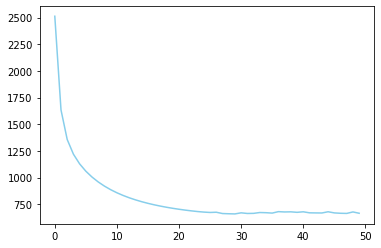

In [19]:
n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [20]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_all_layer=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word) # print the probability of words desc with the word "learning" as input

machine
so
are
intelligence
build
algorithms
the
learning
a
do
automatically
of
is
subset
through
seen
to
as
in
that
variety
training
used
perform
experience
order
improve
study
it
artificial
tasks
such
data
needed
wide
model
conventional
being
filtering
based
mathematical
programmed
known
where
applications
difficult
explicitly
develop
sample
predictions
vision
on
make
or
and
decisions
infeasible
email
without
computer


In [21]:
print(model["w1"][:3]) # the embedding of the first three words

[[ 1.2628424  -0.23199393  0.73341386  0.97447621 -0.41641794 -0.68095658
   2.61265629  0.74214787 -0.05703892 -1.04526872]
 [ 0.28876479  0.72380286  0.41703572 -1.93696817 -0.82172046  0.41757945
  -0.72200732  0.97196456 -1.68163859 -1.42754947]
 [ 0.74553496 -0.69552587 -0.36087355 -1.44234776 -1.25861167  1.99996755
  -1.41716946  0.85665773 -0.21359055 -0.21230389]]


In [22]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [23]:
get_embedding(model, "machine")

array([ 0.00491847, -1.84355269,  0.27607591, -0.93631093, -0.59224958,
        0.19767631, -0.78768098, -1.25834848,  0.70914154, -0.08872889])